In [1]:
# IMPORTS FOR SCRIPT
import pandas as pd
import numpy as np
import calendar
import datetime
import math 
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

pd.set_option('max_rows', None)  #if required to see all results

In [2]:
# Import price dataframes - note use prepare_trade_data.py on coinbase_BTC_EUR.csv prior to running this notebook. Then use crypto_simulation to prepare csv for import
df = pd.read_csv('btc_eur_ohlc_4h_predictive.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)
# Convert date in 'Timestamp' column from strftime to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M")
df.index = df['Timestamp']

In [3]:
# Specify cut-off point for data
year_start = 2018
year_end = 2018

# Or to select a particular month
# df = df.loc[(df['Timestamp'].dt.year == 2018)&(df['Timestamp'].dt.month == 2),:]

df = df.loc[(df['Timestamp'].dt.year >= year_start)&(df['Timestamp'].dt.year <= year_end),:]
df.head(2)

,Timestamp,open,high,low,close,Volume_BTC,rsi,bbupper,bbmiddle,bblower,...,1day_price_change,target,prev_1day_price_change,rsi_ma6,Volume_BTC_ma6,bblower_dist,bbupper_dist,emahist,predicted_target_knn,predicted_target_rf
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,12139.01,11571.13,11762.14,281.697303,43.991789,12520.314608,11846.330,11172.345392,...,-2.114326,sell,-2.896859,43.029307,432.000844,0.437543,0.562457,-512.820481,0,1
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,12141.00,11712.00,11972.68,96.246837,46.830230,12417.708914,11972.866,11528.023086,...,-1.734950,sell,-5.032722,44.654299,419.380003,0.499791,0.500209,-499.405361,0,0


# 1.5 Create Simulations [4h]

<b> Create a blank wallet

In [4]:
# Set up a user BTC wallet - this shows their balance of eur and btc and mid-period price information

# Global parameter - euro start is how much each simulation starts with
eur_start = 1000

# Then set a function to return to this point at later stages    
def reset_wallet():
    wallet = df[['Timestamp','open','close']]
    wallet.index = wallet['Timestamp']
#     wallet.drop(['Timestamp'],axis=1, inplace=True)
    wallet['mid'] = (wallet['open'] + wallet['close']) / 2
    wallet['eur'] = eur_start
    wallet['btc'] = 0
    return wallet

wallet = reset_wallet()
wallet.head(3)

,Timestamp,open,close,mid,eur,btc
Timestamp,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000,0
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,1000,0
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,1000,0


<b> Buy function

In [5]:
# Define a function to buy btc with an amount of euros at time t. (Note sale is executed at start of next period to model realworld lag)
def buy(t, amount, buy_position):
    print ('\n*** BUY ***')
    
    # Account for the fact that at time t, the indicator is only available at close, so you'd buy at t+1 at open or mid
    if len(df['Timestamp'] > t) < 1:
        t_actual = df.iloc[df.index.get_loc(t) + 1]['Timestamp'].strftime('%Y/%m/%d %H:%M:%S')
    else:
        t_actual = t

    print ('t is: ',t_actual)
    print ('EUR sold: ',amount)
    fees = amount*0.003
    print ('fees: ',fees)
    
    # Retrieve price at time given
    price = wallet[wallet.index == t_actual][buy_position].values[0]
    print ('BTC price: ',price)
    
    # Calculate amount of bitcoin bought
    btc_buy = (amount-fees) / price
    print ('BTC bought: ',btc_buy)
    
    # Calculate all future balances to have this amount of btc, and reduce the amount of eur
    wallet.loc[wallet.index >= t_actual,'btc'] += btc_buy
    wallet.loc[wallet.index >= t_actual,'eur'] -= (amount-fees)

#     # Calculate a series of buy locations
#     t_buy_list.append(t)
#     b_list.append(price)
#     buys = pd.DataFrame({'x': t_buy_list, 'y': b_list})
#     return buys

<b>Sell function

In [6]:
# Define a function to sell euros to btc at time t (straight after a signal)
def sell(t, amount, sell_position):
    print ('\n*** SELL ***')
    
    # Account for the fact that at time t, the indicator is only available at close, so you'd sell at t+1 at open or mid
    if len(df['Timestamp'] > t) < 1:
        t_actual = df.iloc[df.index.get_loc(t) + 1]['Timestamp'].strftime('%Y/%m/%d %H:%M:%S')
    else:
        t_actual = t
    
    print ('t is: ',t_actual)
    print ('BTC sold: ',amount)
    
    # Retrieve price at time given
    price = wallet[wallet.index == t_actual][sell_position].values[0]
    print ('BTC price : ',price)
    
    # Calculate amount of euros bought
    eur_buy = amount * price
    fees = eur_buy * 0.003
    print ('fees: ', fees)
    print ('EUR bought: ',(eur_buy-fees))
    
    # Calculate all future balances to have this amount of btc, and reduce the amount of eur
    wallet.loc[wallet.index >= t_actual,'btc'] -= amount
    wallet.loc[wallet.index >= t_actual,'eur'] += (eur_buy-fees)
    
    
#     # Calculate a series of sell locations
#     t_sell_list.append(t)
#     s_list.append(price)
#     sells = pd.DataFrame({'x': t_sell_list, 'y': s_list})
#     return sells

<b> Simulation Function

In [7]:
# SIMULATION FUNCTION - FOLLOW predictions of model in DF (you can use different models for buys vs. sells)
def simulate(sim_buy, sim_sell, switch, start): 
 
    if switch == 'buy' and len(df[(df[sim_buy] == 1) & (df['Timestamp'] > start)]) > 0:
        sell_start = start
        # Find time of buy signal
        buy_start = df[(df[sim_buy] == 1) & (df['Timestamp'] > sell_start)].index[0].strftime('%Y/%m/%d %H:%M:%S')
        eur_start = wallet[wallet['Timestamp'] == buy_start]['eur'].values[0]
        buy(buy_start, eur_start, 'open')
        switch = 'sell'
        simulate(sim_buy, sim_sell, switch, buy_start)        

    elif switch == 'sell' and len(df[(df[sim_sell] == 0) & (df['Timestamp'] > start)]) > 0:
        buy_start = start
        # Find time of sell signal
        sell_start = df[(df[sim_sell] == 0) & (df['Timestamp'] > buy_start)].index[0].strftime('%Y/%m/%d %H:%M:%S')
        eur_start = wallet[wallet['Timestamp'] == sell_start]['btc'].values[0]
        sell(sell_start, eur_start,'open')
        switch = 'buy'
        simulate(sim_buy, sim_sell, switch, sell_start)

<b> Calculate Portfolio Value Function

In [8]:
def get_model_value():
    # Calculate value of trading portfolio
    wallet['value'] = wallet['eur'] + (wallet['btc'] * wallet['mid'])
    wallet['roi'] = ((wallet['value'] - 1000) / eur_start) * 100
    return wallet

<b> Simulation 1 - HODL

In [9]:
# SIMULATION 1 - HODL
# Initiate wallet to starting conditions
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()

# Run buy function (global start time, 1000 euros at mid price)
buy(start, 1000, 'mid')


*** BUY ***
t is:  2018/01/01 00:00:00
EUR sold:  1000
fees:  3.0
BTC price:  11950.575
BTC bought:  0.0834269480757202


In [10]:
sim_hodl = get_model_value()
sim_hodl.head()

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,3.0,0.083427,1000.000000,-1.136868e-14
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,3.0,0.083427,993.044695,-6.955305e-01
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,3.0,0.083427,990.379204,-9.620796e-01
2018-01-01 12:00:00,2018-01-01 12:00:00,11698.34,11642.63,11670.485,3.0,0.083427,976.632946,-2.336705e+00
2018-01-01 16:00:00,2018-01-01 16:00:00,11642.64,11688.00,11665.320,3.0,0.083427,976.202046,-2.379795e+00


<b> Simulation 2 - Random Buy/Sell

In [11]:
np.random.seed(42)
df['randNumCol'] = np.random.randint(0, 2, df.shape[0])

In [12]:
# Set starting trade position
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()

simulate('randNumCol','randNumCol','buy', start)


*** BUY ***
t is:  2018/01/01 04:00:00
EUR sold:  1000
fees:  3.0
BTC price:  11761.73
BTC bought:  0.08476644167142079

*** SELL ***
t is:  2018/01/01 08:00:00
BTC sold:  0.08476644167142079
BTC price :  11972.17
fees:  3.0445147499560017
EUR bought:  1011.7937352353779

*** BUY ***
t is:  2018/01/01 20:00:00
EUR sold:  1014.7937352353779
fees:  3.044381205706134
BTC price:  11687.99
BTC bought:  0.08656316047752195

*** SELL ***
t is:  2018/01/02 00:00:00
BTC sold:  0.08656316047752195
BTC price :  11799.98
fees:  3.0643306871146483
EUR bought:  1018.3792316844348

*** BUY ***
t is:  2018/01/02 12:00:00
EUR sold:  1021.4236128901409
fees:  3.064270838670423
BTC price:  11950.0
BTC bought:  0.08521835498338666

*** SELL ***
t is:  2018/01/02 16:00:00
BTC sold:  0.08521835498338666
BTC price :  12001.18
fees:  3.0681624523785613
EUR bought:  1019.6526550071418

*** BUY ***
t is:  2018/01/03 08:00:00
EUR sold:  1022.7169258458122
fees:  3.0681507775374364
BTC price:  13074.23
BTC bough


*** BUY ***
t is:  2018/01/24 08:00:00
EUR sold:  727.9975362024805
fees:  2.1839926086074417
BTC price:  9012.0
BTC bought:  0.08053856453549413

*** SELL ***
t is:  2018/01/24 12:00:00
BTC sold:  0.08053856453549413
BTC price :  9050.0
fees:  2.186622027138666
EUR bought:  726.6873870190832

*** BUY ***
t is:  2018/01/24 16:00:00
EUR sold:  728.8713796276907
fees:  2.186614138883072
BTC price:  9057.01
BTC bought:  0.08023451067060847

*** SELL ***
t is:  2018/01/25 04:00:00
BTC sold:  0.08023451067060847
BTC price :  9349.67
fees:  2.2504985921450036
EUR bought:  747.9156987895228

*** BUY ***
t is:  2018/01/25 20:00:00
EUR sold:  750.1023129284059
fees:  2.2503069387852177
BTC price:  9097.66
BTC bought:  0.0822026769509545

*** SELL ***
t is:  2018/01/26 00:00:00
BTC sold:  0.0822026769509545
BTC price :  9030.51
fees:  2.2269962886970927
EUR bought:  740.105099943667

*** BUY ***
t is:  2018/01/26 20:00:00
EUR sold:  742.3554068824523
fees:  2.2270662206473566
BTC price:  8871.3


*** SELL ***
t is:  2018/02/14 16:00:00
BTC sold:  0.10534839923051706
BTC price :  7566.99
fees:  2.3915108504799907
EUR bought:  794.7787726428502

*** BUY ***
t is:  2018/02/15 00:00:00
EUR sold:  797.0057722900382
fees:  2.3910173168701148
BTC price:  7661.21
BTC bought:  0.10371922385278148

*** SELL ***
t is:  2018/02/15 16:00:00
BTC sold:  0.10371922385278148
BTC price :  7939.8
fees:  2.4705296806389434
EUR bought:  821.0393638656755

*** BUY ***
t is:  2018/02/15 20:00:00
EUR sold:  823.4303811825456
fees:  2.470291143547637
BTC price:  8190.02
BTC bought:  0.10023908244900474

*** SELL ***
t is:  2018/02/16 00:00:00
BTC sold:  0.10023908244900474
BTC price :  8103.81
fees:  2.4369554362232075
EUR bought:  809.8815233048459

*** BUY ***
t is:  2018/02/16 04:00:00
EUR sold:  812.3518144483936
fees:  2.437055443345181
BTC price:  8135.09
BTC bought:  0.09955818054932992

*** SELL ***
t is:  2018/02/16 08:00:00
BTC sold:  0.09955818054932992
BTC price :  7904.0
fees:  2.36072357


*** BUY ***
t is:  2018/03/10 12:00:00
EUR sold:  886.6441723206252
fees:  2.6599325169618755
BTC price:  7698.64
BTC bought:  0.11482342852811188

*** SELL ***
t is:  2018/03/10 20:00:00
BTC sold:  0.11482342852811188
BTC price :  7424.0
fees:  2.557347400178108
EUR bought:  849.8917859925245

*** BUY ***
t is:  2018/03/11 12:00:00
EUR sold:  852.5517185094865
fees:  2.5576551555284595
BTC price:  7394.46
BTC bought:  0.11495011986730039

*** SELL ***
t is:  2018/03/12 12:00:00
BTC sold:  0.11495011986730039
BTC price :  8028.02
fees:  2.768465583891255
EUR bought:  920.0533957131936

*** BUY ***
t is:  2018/03/12 16:00:00
EUR sold:  922.611050868722
fees:  2.7678331526061664
BTC price:  7450.49
BTC bought:  0.12346076804560718

*** SELL ***
t is:  2018/03/12 20:00:00
BTC sold:  0.12346076804560718
BTC price :  7252.46
fees:  2.686182845460133
EUR bought:  892.7080989745841

*** BUY ***
t is:  2018/03/13 04:00:00
EUR sold:  895.4759321271903
fees:  2.686427796381571
BTC price:  7352.

BTC price :  6370.0
fees:  1.8053315796412335
EUR bought:  599.9718616341032

*** BUY ***
t is:  2018/03/28 00:00:00
EUR sold:  601.8106624976066
fees:  1.8054319874928197
BTC price:  6444.43
BTC bought:  0.09310446858917137

*** SELL ***
t is:  2018/03/28 20:00:00
BTC sold:  0.09310446858917137
BTC price :  6459.01
fees:  1.8040880809864315
EUR bought:  599.5586055811574

*** BUY ***
t is:  2018/03/29 00:00:00
EUR sold:  601.3640375686502
fees:  1.8040921127059508
BTC price:  6458.0
BTC bought:  0.0928398800644076

*** SELL ***
t is:  2018/03/29 04:00:00
BTC sold:  0.0928398800644076
BTC price :  6419.1
fees:  1.7878454223643165
EUR bought:  594.1606286990746

*** BUY ***
t is:  2018/03/29 08:00:00
EUR sold:  595.9647208117805
fees:  1.7878941624353415
BTC price:  6205.9
BTC bought:  0.09574386094673538

*** SELL ***
t is:  2018/03/29 12:00:00
BTC sold:  0.09574386094673538
BTC price :  6079.07
fees:  1.746100898296412
EUR bought:  580.2875318671743

*** BUY ***
t is:  2018/03/29 20:0

*** BUY ***
t is:  2018/04/19 12:00:00
EUR sold:  578.5551930602993
fees:  1.735665579180898
BTC price:  6669.41
BTC bought:  0.08648733958192979

*** SELL ***
t is:  2018/04/19 16:00:00
BTC sold:  0.08648733958192979
BTC price :  6668.79
fees:  1.7302977159917325
EUR bought:  575.0356076145858

*** BUY ***
t is:  2018/04/20 00:00:00
EUR sold:  576.7712731937668
fees:  1.7303138195813004
BTC price:  6697.91
BTC bought:  0.08585379011873637

*** SELL ***
t is:  2018/04/20 04:00:00
BTC sold:  0.08585379011873637
BTC price :  6760.21
fees:  1.7411689514957485
EUR bought:  578.648481547087

*** BUY ***
t is:  2018/04/20 16:00:00
EUR sold:  580.3787953666683
fees:  1.741136386100005
BTC price:  6936.39
BTC bought:  0.08342057741571167

*** SELL ***
t is:  2018/04/21 04:00:00
BTC sold:  0.08342057741571167
BTC price :  7220.09
fees:  1.806912230380217
EUR bought:  600.4971645630254

*** BUY ***
t is:  2018/04/21 12:00:00
EUR sold:  602.2383009491255
fees:  1.8067149028473763
BTC price:  7087

BTC price :  7668.65
fees:  1.6935957526997716
EUR bought:  562.8383218138907

*** BUY ***
t is:  2018/05/09 20:00:00
EUR sold:  564.5603387709449
fees:  1.6936810163128346
BTC price:  7822.0
BTC bought:  0.07195942952628895

*** SELL ***
t is:  2018/05/10 04:00:00
BTC sold:  0.07195942952628895
BTC price :  7861.22
fees:  1.6970667197419598
EUR bought:  563.9918398609112

*** BUY ***
t is:  2018/05/10 12:00:00
EUR sold:  565.685520877224
fees:  1.697056562631672
BTC price:  7891.77
BTC bought:  0.0714653955088139

*** SELL ***
t is:  2018/05/10 20:00:00
BTC sold:  0.0714653955088139
BTC price :  7669.56
fees:  1.644324416335736
EUR bought:  546.4638143622429

*** BUY ***
t is:  2018/05/11 08:00:00
EUR sold:  548.1608709248746
fees:  1.644482612774624
BTC price:  7424.17
BTC bought:  0.07361312959052663

*** SELL ***
t is:  2018/05/11 20:00:00
BTC sold:  0.07361312959052663
BTC price :  7240.01
fees:  1.5988793831001262
EUR bought:  531.3609149836086

*** BUY ***
t is:  2018/05/12 04:0

*** BUY ***
t is:  2018/05/31 04:00:00
EUR sold:  490.25738480912145
fees:  1.4707721544273644
BTC price:  6318.3
BTC bought:  0.07736046288632924

*** SELL ***
t is:  2018/05/31 12:00:00
BTC sold:  0.07736046288632924
BTC price :  6480.1
fees:  1.5039106066491064
EUR bought:  499.799624943053

*** BUY ***
t is:  2018/05/31 20:00:00
EUR sold:  501.2703970974804
fees:  1.5038111912924412
BTC price:  6479.13
BTC bought:  0.07713482919870229

*** SELL ***
t is:  2018/06/01 04:00:00
BTC sold:  0.07713482919870229
BTC price :  6414.87
fees:  1.4844297053456381
EUR bought:  493.32547207653374

*** BUY ***
t is:  2018/06/01 12:00:00
EUR sold:  494.82928326782616
fees:  1.4844878498034786
BTC price:  6462.9
BTC bought:  0.07633489539030817

*** SELL ***
t is:  2018/06/01 16:00:00
BTC sold:  0.07633489539030817
BTC price :  6380.0
fees:  1.4610498977704984
EUR bought:  485.5555826923956

*** BUY ***
t is:  2018/06/02 04:00:00
EUR sold:  487.0400705421991
fees:  1.4611202116265973
BTC price:  64

In [13]:
sim_rand= get_model_value()
sim_rand.head(3)

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000.000000,0.000000,1000.000000,0.000000
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,3.000000,0.084766,1008.940740,0.894074
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,1014.793735,0.000000,1014.793735,1.479374


<b> Simulation 3 - RSI boundaries

In [14]:
# SIMULATION 2 - FOLLOW RSI [4H] on hitting 30 / 70
def rsi_sim(switch, start):
    if switch == 'buy':
        sell_start = start
        # Find time of first buy signal  
        df['rsi_signal'] = df.apply(lambda row: row["rsi"] < 30 and row["rsi_diff"] < 0, axis=1)
        
        if df[(df['rsi_signal'] == True) & (df['Timestamp'] > sell_start)]['rsi_signal'].count() == 0:
            pass
        else:
            buy_start = df[(df['rsi_signal'] == True) & (df['Timestamp'] > sell_start)].index[0].strftime('%Y/%m/%d %H:%M:%S')
            eur_start = wallet[wallet['Timestamp'] == buy_start]['eur'].values[0]
            buy(buy_start, eur_start, 'open')
            switch = 'sell'
            rsi_sim(switch,buy_start)
        
    elif switch == 'sell':
        buy_start = start
        # Find time of sell signal
        df['rsi_signal'] = df.apply(lambda row: row["rsi"] > 70 and row["rsi_diff"] > 0, axis=1)
        
        if df[(df['rsi_signal'] == True) & (df['Timestamp'] > buy_start)]['rsi_signal'].count() == 0:
            pass
        else:
            sell_start = df[(df['rsi_signal'] == True) & (df['Timestamp'] > buy_start)].index[0].strftime('%Y/%m/%d %H:%M:%S')
            eur_start = wallet[wallet['Timestamp'] == sell_start]['btc'].values[0]
            sell(sell_start, eur_start, 'open')
            switch = 'buy'
            rsi_sim(switch,sell_start)

In [15]:
# RSI SIMULATION - Set starting trade position
# Initiate wallet to starting conditions
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()
df['rsi_diff'] = df['rsi'].diff() 

rsi_sim('buy', start)


*** BUY ***
t is:  2018/01/16 04:00:00
EUR sold:  1000
fees:  3.0
BTC price:  10700.01
BTC bought:  0.09317748301169812

*** SELL ***
t is:  2018/02/15 04:00:00
BTC sold:  0.09317748301169812
BTC price :  7780.68
fees:  2.174952535558378
EUR bought:  722.8092259839009

*** BUY ***
t is:  2018/03/07 16:00:00
EUR sold:  725.8092259839009
fees:  2.1774276779517026
BTC price:  8610.0
BTC bought:  0.08404550502972696

*** SELL ***
t is:  2018/04/12 12:00:00
BTC sold:  0.08404550502972696
BTC price :  5632.01
fees:  1.4200353743474177
EUR bought:  471.92508940812513

*** BUY ***
t is:  2018/05/11 04:00:00
EUR sold:  474.1025170860769
fees:  1.4223075512582306
BTC price:  7487.7
BTC bought:  0.06312755713167176


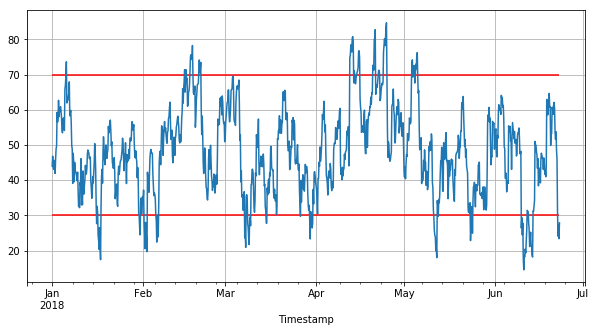

In [16]:
fig, ax = plt.subplots()
df['rsi'].plot(figsize=(10,5), ax=ax, grid=True)
ax.hlines(y=30, xmin=df['rsi'].index.min(), xmax=df['rsi'].index.max(), color='r')
ax.hlines(y=70, xmin=df['rsi'].index.min(), xmax=df['rsi'].index.max(), color='r');

In [17]:
sim_rsi_boundary = get_model_value()
sim_rsi_boundary.head(3)

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000.0,0.0,1000.0,0.0
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,1000.0,0.0,1000.0,0.0
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,1000.0,0.0,1000.0,0.0


<b> Simulation 4 - KNN Model

In [18]:
# Set starting trade position - KNN model [4h]
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()

time_buys = []     
time_sells = []   
buy_prices = []           
sell_prices = []          

simulate('predicted_target_knn','predicted_target_knn', 'buy', start)


*** BUY ***
t is:  2018/01/01 08:00:00
EUR sold:  1000
fees:  3.0
BTC price:  11972.17
BTC bought:  0.08327646533585807

*** SELL ***
t is:  2018/01/02 12:00:00
BTC sold:  0.08327646533585807
BTC price :  11950.0
fees:  2.985461282290512
EUR bought:  992.1682994812135

*** BUY ***
t is:  2018/01/02 16:00:00
EUR sold:  995.1682994812135
fees:  2.9855048984436405
BTC price:  12001.18
BTC bought:  0.08267376996118463

*** SELL ***
t is:  2018/01/03 04:00:00
BTC sold:  0.08267376996118463
BTC price :  12630.94
fees:  3.1327422838605763
EUR bought:  1041.1146856696648

*** BUY ***
t is:  2018/01/03 16:00:00
EUR sold:  1044.1001905681085
fees:  3.1323005717043255
BTC price:  13000.0
BTC bought:  0.08007445307664648

*** SELL ***
t is:  2018/01/03 20:00:00
BTC sold:  0.08007445307664648
BTC price :  12950.46
fees:  3.1110030047729618
EUR bought:  1033.8899985862142

*** BUY ***
t is:  2018/01/04 08:00:00
EUR sold:  1037.0222991579185
fees:  3.1110668974737554
BTC price:  12920.06
BTC bought:


*** BUY ***
t is:  2018/02/25 08:00:00
EUR sold:  736.0544998185413
fees:  2.208163499455624
BTC price:  7948.53
BTC bought:  0.09232478663590446

*** SELL ***
t is:  2018/02/26 20:00:00
BTC sold:  0.09232478663590446
BTC price :  8334.74
fees:  2.308509276497215
EUR bought:  767.194582889241

*** BUY ***
t is:  2018/02/27 00:00:00
EUR sold:  769.4027463886966
fees:  2.30820823916609
BTC price:  8380.0
BTC bought:  0.09153872770280794

*** SELL ***
t is:  2018/02/27 08:00:00
BTC sold:  0.09153872770280794
BTC price :  8610.67
fees:  2.364629329406212
EUR bought:  785.8451471393311

*** BUY ***
t is:  2018/02/28 08:00:00
EUR sold:  788.1533553784972
fees:  2.3644600661354915
BTC price:  8817.52
BTC bought:  0.08911676926305374

*** SELL ***
t is:  2018/03/01 08:00:00
BTC sold:  0.08911676926305374
BTC price :  8658.99
fees:  2.314983641643269
EUR bought:  769.3462302394464

*** BUY ***
t is:  2018/03/01 12:00:00
EUR sold:  771.7106903055819
fees:  2.315132070916746
BTC price:  8728.43



*** SELL ***
t is:  2018/04/05 04:00:00
BTC sold:  0.11661794115262396
BTC price :  5399.99
fees:  1.8892071481342736
EUR bought:  627.8465088966236

*** BUY ***
t is:  2018/04/05 20:00:00
EUR sold:  629.8081466537893
fees:  1.889424439961368
BTC price:  5488.2
BTC bought:  0.11441250723622098

*** SELL ***
t is:  2018/04/06 08:00:00
BTC sold:  0.11441250723622098
BTC price :  5396.52
fees:  1.852288150651234
EUR bought:  615.5770953997601

*** BUY ***
t is:  2018/04/06 12:00:00
EUR sold:  617.4665198397214
fees:  1.8523995595191642
BTC price:  5352.0
BTC bought:  0.11502505984308711

*** SELL ***
t is:  2018/04/08 08:00:00
BTC sold:  0.11502505984308711
BTC price :  5629.01
fees:  1.9424316363220075
EUR bought:  645.5347804710138

*** BUY ***
t is:  2018/04/09 08:00:00
EUR sold:  647.387180030533
fees:  1.9421615400915992
BTC price:  5804.99
BTC bought:  0.11118796388804142

*** SELL ***
t is:  2018/04/13 12:00:00
BTC sold:  0.11118796388804142
BTC price :  6571.8
fees:  2.1921151832


*** SELL ***
t is:  2018/05/18 20:00:00
BTC sold:  0.0857351929549869
BTC price :  6986.01
fees:  1.7968407460064042
EUR bought:  597.1500745894616

*** BUY ***
t is:  2018/05/19 00:00:00
EUR sold:  598.975259036827
fees:  1.796925777110481
BTC price:  7000.01
BTC bought:  0.08531106859271866

*** SELL ***
t is:  2018/05/19 08:00:00
BTC sold:  0.08531106859271866
BTC price :  7009.9
fees:  1.7940661791842956
EUR bought:  596.2279935489142

*** BUY ***
t is:  2018/05/19 12:00:00
EUR sold:  598.0249193260247
fees:  1.794074757978074
BTC price:  7016.6
BTC bought:  0.08497432439757813

*** SELL ***
t is:  2018/05/20 16:00:00
BTC sold:  0.08497432439757813
BTC price :  7096.28
fees:  1.8090047962081373
EUR bought:  601.1925939398376

*** BUY ***
t is:  2018/05/23 16:00:00
EUR sold:  602.9866686978156
fees:  1.808960006093447
BTC price:  6751.1
BTC bought:  0.08904885258575967

*** SELL ***
t is:  2018/05/24 12:00:00
BTC sold:  0.08904885258575967
BTC price :  6280.0
fees:  1.6776803827157

In [19]:
sim_knn = get_model_value()
sim_knn

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000.000000,0.000000,1000.000000,0.000000
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,1000.000000,0.000000,1000.000000,0.000000
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,3.000000,0.083276,988.598203,-1.140180
2018-01-01 12:00:00,2018-01-01 12:00:00,11698.34,11642.63,11670.485,3.000000,0.083276,974.876740,-2.512326
2018-01-01 16:00:00,2018-01-01 16:00:00,11642.64,11688.00,11665.320,3.000000,0.083276,974.446617,-2.555338
2018-01-01 20:00:00,2018-01-01 20:00:00,11687.99,11799.98,11743.985,3.000000,0.083276,980.997560,-1.900244
2018-01-02 00:00:00,2018-01-02 00:00:00,11799.98,11513.45,11656.715,3.000000,0.083276,973.730023,-2.626998
2018-01-02 04:00:00,2018-01-02 04:00:00,11511.90,11764.96,11638.430,3.000000,0.083276,972.207312,-2.779269
2018-01-02 08:00:00,2018-01-02 08:00:00,11764.96,11950.00,11857.480,3.000000,0.083276,990.449022,-0.955098


<b> Simulation 5 - RF Model

In [20]:
# Set starting trade position - RF model [4h]
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()      

simulate('predicted_target_rf','predicted_target_rf', 'buy', start)


*** BUY ***
t is:  2018/01/01 12:00:00
EUR sold:  1000
fees:  3.0
BTC price:  11698.34
BTC bought:  0.08522576707464478

*** SELL ***
t is:  2018/01/02 12:00:00
BTC sold:  0.08522576707464478
BTC price :  11950.0
fees:  3.0553437496260156
EUR bought:  1015.3925727923792

*** BUY ***
t is:  2018/01/02 16:00:00
EUR sold:  1018.3925727923792
fees:  3.0551777183771374
BTC price:  12001.18
BTC bought:  0.08460313028168914

*** SELL ***
t is:  2018/01/03 04:00:00
BTC sold:  0.08460313028168914
BTC price :  12630.94
fees:  3.205851187200596
EUR bought:  1065.411211212998

*** BUY ***
t is:  2018/01/04 08:00:00
EUR sold:  1068.4663889313751
fees:  3.2053991667941255
BTC price:  12920.06
BTC bought:  0.08245015810797945

*** SELL ***
t is:  2018/01/05 20:00:00
BTC sold:  0.08245015810797945
BTC price :  13862.44
fees:  3.4288811092871367
EUR bought:  1139.5314886530916

*** BUY ***
t is:  2018/01/06 00:00:00
EUR sold:  1142.7368878198859
fees:  3.4282106634596574
BTC price:  14299.99
BTC bough

*** SELL ***
t is:  2018/02/24 08:00:00
BTC sold:  0.09245303984282262
BTC price :  8286.0
fees:  2.2981976644128848
EUR bought:  763.7676904732153

*** BUY ***
t is:  2018/02/24 20:00:00
EUR sold:  766.1231565364526
fees:  2.2983694696093577
BTC price:  7820.0
BTC bought:  0.0976758039727421

*** SELL ***
t is:  2018/02/25 04:00:00
BTC sold:  0.0976758039727421
BTC price :  7829.26
fees:  2.2941877950348926
EUR bought:  762.4350772165959

*** BUY ***
t is:  2018/02/25 08:00:00
EUR sold:  764.7334466862053
fees:  2.294200340058616
BTC price:  7948.53
BTC bought:  0.09592204424543238

*** SELL ***
t is:  2018/02/27 08:00:00
BTC sold:  0.09592204424543238
BTC price :  8610.67
fees:  2.4778592061684517
EUR bought:  823.4752095166488

*** BUY ***
t is:  2018/02/28 04:00:00
EUR sold:  825.7694098567074
fees:  2.4773082295701223
BTC price:  8872.75
BTC bought:  0.09278883115461804

*** SELL ***
t is:  2018/03/01 16:00:00
BTC sold:  0.09278883115461804
BTC price :  8797.0
fees:  2.44879004300


*** BUY ***
t is:  2018/04/02 00:00:00
EUR sold:  490.69099500194534
fees:  1.472072985005836
BTC price:  5529.82
BTC bought:  0.08846923082793645

*** SELL ***
t is:  2018/04/03 04:00:00
BTC sold:  0.08846923082793645
BTC price :  5839.99
fees:  1.5499782700285218
EUR bought:  515.109445072812

*** BUY ***
t is:  2018/04/04 16:00:00
EUR sold:  516.5815180578179
fees:  1.5497445541734538
BTC price:  5590.2
BTC bought:  0.09213118913520885

*** SELL ***
t is:  2018/04/05 04:00:00
BTC sold:  0.09213118913520885
BTC price :  5399.99
fees:  1.492522500054709
EUR bought:  496.0149775181817

*** BUY ***
t is:  2018/04/06 00:00:00
EUR sold:  497.56472207235515
fees:  1.4926941662170654
BTC price:  5574.2
BTC bought:  0.08899430015179544

*** SELL ***
t is:  2018/04/08 08:00:00
BTC sold:  0.08899430015179544
BTC price :  5629.01
fees:  1.5028494164923742
EUR bought:  499.44695608096566

*** BUY ***
t is:  2018/04/09 08:00:00
EUR sold:  500.9396502471827
fees:  1.5028189507415481
BTC price:  5


*** SELL ***
t is:  2018/05/29 08:00:00
BTC sold:  0.06388317719110283
BTC price :  6131.31
fees:  1.175062689430742
EUR bought:  390.51250045415

*** BUY ***
t is:  2018/05/29 12:00:00
EUR sold:  391.71428718677225
fees:  1.1751428615603168
BTC price:  6220.0
BTC bought:  0.06278764378218842

*** SELL ***
t is:  2018/05/29 16:00:00
BTC sold:  0.06278764378218842
BTC price :  6435.02
fees:  1.2121192304737745
EUR bought:  402.8276242607844

*** BUY ***
t is:  2018/05/30 04:00:00
EUR sold:  404.00276712234466
fees:  1.212008301367034
BTC price:  6526.48
BTC bought:  0.061716385987695924

*** SELL ***
t is:  2018/05/30 08:00:00
BTC sold:  0.061716385987695924
BTC price :  6470.81
fees:  1.198065022839128
EUR bought:  398.1569425902036

*** BUY ***
t is:  2018/05/30 12:00:00
EUR sold:  399.3689508915706
fees:  1.1981068526747118
BTC price:  6490.54
BTC bought:  0.061346335441873234

*** SELL ***
t is:  2018/05/31 04:00:00
BTC sold:  0.061346335441873234
BTC price :  6318.3
fees:  1.16281

In [21]:
sim_rf = get_model_value()
sim_rf.head()

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000.0,0.000000,1000.000000,0.000000
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,1000.0,0.000000,1000.000000,0.000000
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,1000.0,0.000000,1000.000000,0.000000
2018-01-01 12:00:00,2018-01-01 12:00:00,11698.34,11642.63,11670.485,3.0,0.085226,997.626036,-0.237396
2018-01-01 16:00:00,2018-01-01 16:00:00,11642.64,11688.00,11665.320,3.0,0.085226,997.185845,-0.281415


<b> Simulation 6 - KNN for buys, RandomForest for sells

In [22]:
# Set starting trade position - RF model [4h]
start = wallet.Timestamp[0].strftime('%Y/%m/%d %H:%M:%S')
wallet = reset_wallet()      

simulate('predicted_target_knn','predicted_target_rf', 'buy', start)


*** BUY ***
t is:  2018/01/01 08:00:00
EUR sold:  1000
fees:  3.0
BTC price:  11972.17
BTC bought:  0.08327646533585807

*** SELL ***
t is:  2018/01/02 12:00:00
BTC sold:  0.08327646533585807
BTC price :  11950.0
fees:  2.985461282290512
EUR bought:  992.1682994812135

*** BUY ***
t is:  2018/01/02 16:00:00
EUR sold:  995.1682994812135
fees:  2.9855048984436405
BTC price:  12001.18
BTC bought:  0.08267376996118463

*** SELL ***
t is:  2018/01/03 04:00:00
BTC sold:  0.08267376996118463
BTC price :  12630.94
fees:  3.1327422838605763
EUR bought:  1041.1146856696648

*** BUY ***
t is:  2018/01/03 16:00:00
EUR sold:  1044.1001905681085
fees:  3.1323005717043255
BTC price:  13000.0
BTC bought:  0.08007445307664648

*** SELL ***
t is:  2018/01/03 20:00:00
BTC sold:  0.08007445307664648
BTC price :  12950.46
fees:  3.1110030047729618
EUR bought:  1033.8899985862142

*** BUY ***
t is:  2018/01/04 08:00:00
EUR sold:  1037.0222991579185
fees:  3.1110668974737554
BTC price:  12920.06
BTC bought:


*** BUY ***
t is:  2018/02/13 04:00:00
EUR sold:  752.4765541392946
fees:  2.257429662417884
BTC price:  7151.66
BTC bought:  0.10490139694516754

*** SELL ***
t is:  2018/02/17 04:00:00
BTC sold:  0.10490139694516754
BTC price :  8448.99
fees:  2.658932561327253
EUR bought:  883.6519212144239

*** BUY ***
t is:  2018/02/17 08:00:00
EUR sold:  885.9093508768417
fees:  2.6577280526305254
BTC price:  8712.02
BTC bought:  0.10138310320961283

*** SELL ***
t is:  2018/02/17 20:00:00
BTC sold:  0.10138310320961283
BTC price :  8727.65
fees:  2.654508722182132
EUR bought:  882.1817320051952

*** BUY ***
t is:  2018/02/18 08:00:00
EUR sold:  884.8394600578257
fees:  2.654518380173477
BTC price:  8667.0
BTC bought:  0.1017866553222167

*** SELL ***
t is:  2018/02/18 20:00:00
BTC sold:  0.1017866553222167
BTC price :  8770.51
fees:  2.6781626351101644
EUR bought:  890.0427157349446

*** BUY ***
t is:  2018/02/19 00:00:00
EUR sold:  892.6972341151181
fees:  2.6780917023453545
BTC price:  8442.0


*** BUY ***
t is:  2018/03/27 08:00:00
EUR sold:  826.017664403663
fees:  2.4780529932109894
BTC price:  6432.69
BTC bought:  0.1280241409753077

*** SELL ***
t is:  2018/03/27 12:00:00
BTC sold:  0.1280241409753077
BTC price :  6468.63
fees:  2.484422397111314
EUR bought:  825.6563766399934

*** BUY ***
t is:  2018/03/27 16:00:00
EUR sold:  828.1344296332044
fees:  2.484403288899613
BTC price:  6523.52
BTC bought:  0.12656510999342452

*** SELL ***
t is:  2018/03/28 04:00:00
BTC sold:  0.12656510999342452
BTC price :  6303.69
fees:  2.3934816546433506
EUR bought:  795.4337365598068

*** BUY ***
t is:  2018/03/30 00:00:00
EUR sold:  797.9181398487063
fees:  2.393754419546119
BTC price:  5827.97
BTC bought:  0.1365011119530746

*** SELL ***
t is:  2018/03/30 04:00:00
BTC sold:  0.1365011119530746
BTC price :  5556.51
fees:  2.2754093807351357
EUR bought:  756.1943841976434

*** BUY ***
t is:  2018/03/30 12:00:00
EUR sold:  758.5881386171895
fees:  2.275764415851569
BTC price:  5591.6
B


*** SELL ***
t is:  2018/05/18 20:00:00
BTC sold:  0.09132704271042548
BTC price :  6986.01
fees:  1.9140349009363784
EUR bought:  636.0975987445231

*** BUY ***
t is:  2018/05/19 00:00:00
EUR sold:  638.041825989296
fees:  1.9141254779678878
BTC price:  7000.01
BTC bought:  0.09087525596553833

*** SELL ***
t is:  2018/05/20 16:00:00
BTC sold:  0.09087525596553833
BTC price :  7096.28
fees:  1.934628784209391
EUR bought:  642.941632618921

*** BUY ***
t is:  2018/05/23 16:00:00
EUR sold:  644.8557580968888
fees:  1.9345672742906665
BTC price:  6751.1
BTC bought:  0.09523206452616584

*** SELL ***
t is:  2018/05/24 04:00:00
BTC sold:  0.09523206452616584
BTC price :  6481.35
fees:  1.851697024249995
EUR bought:  615.380644392415

*** BUY ***
t is:  2018/05/24 08:00:00
EUR sold:  617.3152116667056
fees:  1.8519456350001169
BTC price:  6545.21
BTC bought:  0.0940326232514626

*** SELL ***
t is:  2018/05/24 12:00:00
BTC sold:  0.0940326232514626
BTC price :  6280.0
fees:  1.7715746220575

In [23]:
sim_knn_rf = get_model_value()
sim_knn_rf.head()

,Timestamp,open,close,mid,eur,btc,value,roi
Timestamp,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,12139.01,11762.14,11950.575,1000.0,0.000000,1000.000000,0.000000
2018-01-01 04:00:00,2018-01-01 04:00:00,11761.73,11972.68,11867.205,1000.0,0.000000,1000.000000,0.000000
2018-01-01 08:00:00,2018-01-01 08:00:00,11972.17,11698.34,11835.255,3.0,0.083276,988.598203,-1.140180
2018-01-01 12:00:00,2018-01-01 12:00:00,11698.34,11642.63,11670.485,3.0,0.083276,974.876740,-2.512326
2018-01-01 16:00:00,2018-01-01 16:00:00,11642.64,11688.00,11665.320,3.0,0.083276,974.446617,-2.555338


# 1.6 Plot simulation comparisons

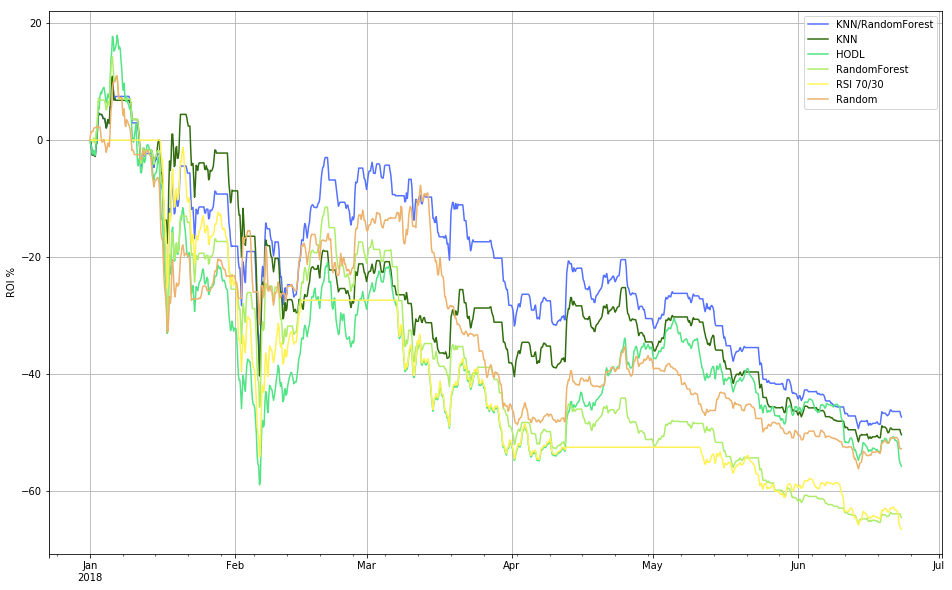

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(16,10))

sim_knn_rf['roi'].plot(ax=ax, color='#5571FF', label='KNN/RandomForest')
sim_knn['roi'].plot(ax=ax, color='#316D0E', label='KNN')
sim_hodl['roi'].plot(ax=ax, color='#53E485',label='HODL')
sim_rf['roi'].plot(ax=ax, color='#AEED6B', label='RandomForest')
sim_rsi_boundary['roi'].plot(ax=ax, color='#FFF255',label='RSI 70/30')
sim_rand['roi'].plot(ax=ax, color='#EDB26B', label='Random', grid=True)

ax.set_title='Model simulation comparison'
ax.legend(loc='upper right')
ax.set_xlabel("")
ax.set_ylabel("ROI %");

fig.savefig('simulations_H1_2018.png')